In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import gdown
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio

import micro
import gtsa

## Download sample data

In [3]:
url = 'https://drive.google.com/drive/folders/1CxLSaQl8VzsGrKUJUVjRUh2yYwWJGNrl'
dem_folder='../data/dems'
gdown.download_folder(url, output=dem_folder, quiet=False, use_cookies=False)

url = 'https://drive.google.com/drive/folders/1KVlr6hueLEqRIfizw74y0VAR_m9i6jlI'
vector_folder='../data/vectors'
gdown.download_folder(url, output=vector_folder, quiet=False, use_cookies=False)

Retrieving folder list


Processing file 1M5urMzDTND5cOjmimRECi3041ayX5TJD KID13_hpgf_20201109_20210208_sfm.tif
Processing file 1yevAG3FY73cEeej6WCFixEcMHhgenIyT KID13_hpgf_20201109_20210406_sfm.tif
Processing file 1d_kU0roLaqxAQK2pJEX7alwdh-kDs0yY KID13_hpgf_20201109_20210513_LiDAR.tif
Processing file 1ulSD0TpPj8UsK2ucZCtrOpQU3fOcypdk KID13_hpgf_20201109_20210513_sfm.tif
Processing file 1O91mLkTbXqcY6Ych4PklI1-eeeFkenP8 wsyr1_20201109_KID13_LiDAR.tif
Processing file 13jUvQ4MGxNlajOv_-wKIvPyMZoR5XbaY wsyr1_20201109_KID13_sfm.tif
Processing file 1xkI-VDyD3jfEM1nx4yJUcQTSizLGKTF_ wsyr1_20210208_KID13_sfm.tif
Processing file 1fSpRAY8Av-dNwBCTiPJ8_KhsQYTB9x_I wsyr1_20210406_KID13_sfm.tif
Processing file 15OGlcttgtjKBjJqcwcS-T5GnlGY-n7WE wsyr1_20210513_KID13_LiDAR.tif
Processing file 1scEnHTWHAkdxKLeJnnKEWb7F0Sbm8Am- wsyr1_20210513_KID13_sfm.tif
Building directory structure completed


Retrieving folder list completed
Building directory structure


Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1M5urMzDTND5cOjmimRECi3041ayX5TJD 

Download ended unsuccessfully
Retrieving folder list


Processing file 1QNRKa8SUQpSJalUfOfhOfDvrct4VTtlr wsyr1_KID13_ruts.cpg
Processing file 1ZMmG805NccYEDT2gWwIbIGDGO_dVBukp wsyr1_KID13_ruts.dbf
Processing file 1RZrdlkpUsQ5KDdfJa1zos6iXQphKrLNC wsyr1_KID13_ruts.prj
Processing file 1G-jySr_Hr9lV5S0Wa18AuvdoCRIKKzYy wsyr1_KID13_ruts.shp
Processing file 1Arv3Esis3FjJsb7xzRTC3eQfrDu4CCOM wsyr1_KID13_ruts.shx
Building directory structure completed


Retrieving folder list completed
Building directory structure


Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1QNRKa8SUQpSJalUfOfhOfDvrct4VTtlr 

Download ended unsuccessfully


In [4]:
!tree ../data/

/bin/bash: line 1: tree: command not found


In [5]:
dsm_files = sorted(Path(dem_folder).glob('ws*.tif'))
dsm_files = [i.as_posix() for i in dsm_files] # convert from posix path to string

In [6]:
dsm_files

['../data/dems/wsyr1_20201109_KID13_LiDAR.tif',
 '../data/dems/wsyr1_20201109_KID13_sfm.tif',
 '../data/dems/wsyr1_20210208_KID13_sfm.tif',
 '../data/dems/wsyr1_20210406_KID13_sfm.tif',
 '../data/dems/wsyr1_20210513_KID13_LiDAR.tif',
 '../data/dems/wsyr1_20210513_KID13_sfm.tif']

## Select analysis ready data
- Assuming SfM and lidar collected on the same data are only used for validation of the SfM data
- Assuming the lidar is always "better" and will thus be used for the quantitative measurements and time series analysis

In [7]:
dsm_files = ['../data/dems/wsyr1_20201109_KID13_LiDAR.tif',
             # '../data/dems/wsyr1_20201109_KID13_sfm.tif',
             '../data/dems/wsyr1_20210208_KID13_sfm.tif',
             '../data/dems/wsyr1_20210406_KID13_sfm.tif',
             '../data/dems/wsyr1_20210513_KID13_LiDAR.tif',
            #  '../data/dems/wsyr1_20210513_KID13_sfm.tif',
            ]

## Parse time stamps

In [8]:
strings = gtsa.io.parse_timestamps(dsm_files, date_string_pattern='_........_')
date_strings = [x[1:-1] for x in strings]

# ensure chronological sorting
date_strings, dsm_files = list(zip(*sorted(zip(date_strings, dsm_files))))
date_times = [pd.to_datetime(x, format='%Y%m%d') for x in date_strings]

In [9]:
list(zip(date_strings, dsm_files))

[('20201109', '../data/dems/wsyr1_20201109_KID13_LiDAR.tif'),
 ('20210208', '../data/dems/wsyr1_20210208_KID13_sfm.tif'),
 ('20210406', '../data/dems/wsyr1_20210406_KID13_sfm.tif'),
 ('20210513', '../data/dems/wsyr1_20210513_KID13_LiDAR.tif')]

## Create stack
- resample to reference DEM grid and save as netcdf

In [10]:
reference_dem = dsm_files[0]

ds = gtsa.io.xr_stack_geotifs(
    dsm_files,
    date_times,
    reference_dem,
    resampling='cubic',
    save_to_nc=True,
    overwrite=True,
    cleanup=False,
    verbose=True,
)

Resampled 4 of 4 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.
Reading files from ../data/dems


## Ensure `nodata` values are correct

In [11]:
ds_nodata = ds.band1
nd = np.nanmax(ds_nodata.isel(time=1).values)
ds_nodata = ds_nodata.where(ds_nodata!=nd)

print(f"nodata: {ds_nodata.rio.nodata}")
print(f"encoded_nodata: {ds_nodata.rio.encoded_nodata}")

nodata: None
encoded_nodata: None


In [12]:
ds_nodata.rio.write_nodata(nd, encoded=True,inplace=True)

print(f"nodata: {ds_nodata.rio.nodata}")
print(f"encoded_nodata: {ds_nodata.rio.encoded_nodata}")

nodata: nan
encoded_nodata: 3.4028234663852886e+38


## Plot first time stamp

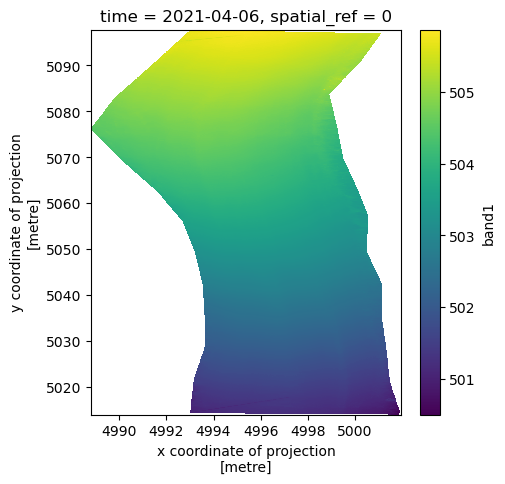

In [13]:
ds_nodata.isel(time=2).plot(aspect='equal',
                              size=5)

## Compute differences for stack

In [14]:
ds_diff = ds_nodata.diff(dim='time')

## Apply HPGF to stacked dataset

In [15]:
#Compiled from pygeotools (dshean) and himat2cryo repositories
#given to me by Shashank

def checkma(a, fix=False):
    #isinstance(a, np.ma.MaskedArray)
    if np.ma.is_masked(a):
        out=a
    else:
        out=np.ma.array(a)
    #added to original code:
    return out

def maskfill(a, iterations=1, erode=False):
    import scipy.ndimage as ndimage 
    a = checkma(a)
    if erode:
        a = mask_islands(a, iterations)
    bmask = (~np.ma.getmaskarray(a))
    bmask_filled = ndimage.morphology.binary_fill_holes(bmask)
    #This will create valid values with a.filled in the original ma
    #a_erode.mask[:] = ~bmask_filled
    #return a_erode
    return ~bmask_filled

def gauss_fltr_astropy_fft(dem, size=None, sigma=None, origmask=False, fill_interior=False):
    
    """
    ***From pygeotools, commit to mainstream repo after full testing***
    # I use this over the direct Gaussian astropy filter  as it is way faster for large kernels
    Astropy gaussian filter properly handles convolution with NaN
    http://stackoverflow.com/questions/23832852/by-which-measures-should-i-set-the-size-of-my-gaussian-filter-in-matlab
    width1 = 3; sigma1 = (width1-1) / 6;
    Specify width for smallest feature of interest and determine sigma appropriately
    sigma is width of 1 std in pixels (not multiplier)
    scipy and astropy both use cutoff of 4*sigma on either side of kernel - 99.994%
    3*sigma on either side of kernel - 99.7%
    If sigma is specified, filter width will be a multiple of 8 times sigma 
    Alternatively, specify filter size, then compute sigma: sigma = (size - 1) / 8.
    If size is < the required width for 6-8 sigma, need to use different mode to create kernel
    mode 'oversample' and 'center' are essentially identical for sigma 1, but very different for sigma 0.3
    The sigma/size calculations below should work for non-integer sigma
    """

    #import astropy.nddata
    import astropy.convolution
    dem = checkma(dem)
    #Generate 2D gaussian kernel for input sigma and size
    #Default size is 8*sigma in x and y directions
    #kernel = astropy.nddata.make_kernel([size, size], sigma, 'gaussian')
    #Size must be odd
    if size is not None:
        size = int(np.floor(size/2)*2 + 1)
        size = max(size, 3)
    #Truncate the filter at this many standard deviations. Default is 4.0
    truncate = 3.0
    if size is not None and sigma is None:
        sigma = (size - 1) / (2*truncate)
    elif size is None and sigma is not None:
        #Round up to nearest odd int
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    elif size is None and sigma is None:
        #Use default parameters
        sigma = 1
        size = int(np.ceil((sigma * (2*truncate) + 1)/2)*2 - 1)
    size = max(size, 3)
    kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=size, y_size=size, mode='oversample')

    print("Applying gaussian smoothing filter with size %i and sigma %0.3f (sum %0.3f)" % \
            (size, sigma, kernel.array.sum()))

    #This will fill holes
    #np.nan is float
    #dem_filt_gauss = astropy.nddata.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #dem_filt_gauss = astropy.convolution.convolve(dem.astype(float).filled(np.nan), kernel, boundary='fill', fill_value=np.nan)
    #Added normalization to ensure filtered values are not brightened/darkened if kernelsum != 1
    dem_filt_gauss = astropy.convolution.convolve_fft(dem.astype(float).filled(np.nan), kernel, boundary='fill', 
                                                      fill_value=np.nan, normalize_kernel=True,
                                                     allow_huge=True)
    #This will preserve original ndv pixels, applying original mask after filtering
    if origmask:
        print("Applying original mask")
        #Allow filling of interior holes, but use original outer edge
        if fill_interior:
            mask = maskfill(dem)
        else:
            mask = dem.mask
        dem_filt_gauss = np.ma.array(dem_filt_gauss, mask=mask, fill_value=dem.fill_value)
    out = np.ma.fix_invalid(dem_filt_gauss, copy=False, fill_value=dem.fill_value)
    out.set_fill_value(dem.fill_value.astype(dem.dtype))
    return out.astype(dem.dtype), size

In [16]:
sigma = 50
ds_diff_smooth0, size = gauss_fltr_astropy_fft(ds_diff.isel(time=0).values, sigma = sigma, origmask=True)
ds_diff_smooth1, size = gauss_fltr_astropy_fft(ds_diff.isel(time=1).values, sigma = sigma, origmask=True)
ds_diff_smooth2, size = gauss_fltr_astropy_fft(ds_diff.isel(time=2).values, sigma = sigma, origmask=True)

Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask
Applying gaussian smoothing filter with size 301 and sigma 50.000 (sum 1.000)
Applying original mask


In [17]:
ds_diff = ds_diff - [ds_diff_smooth0,ds_diff_smooth1,ds_diff_smooth2]

## Plot first difference map

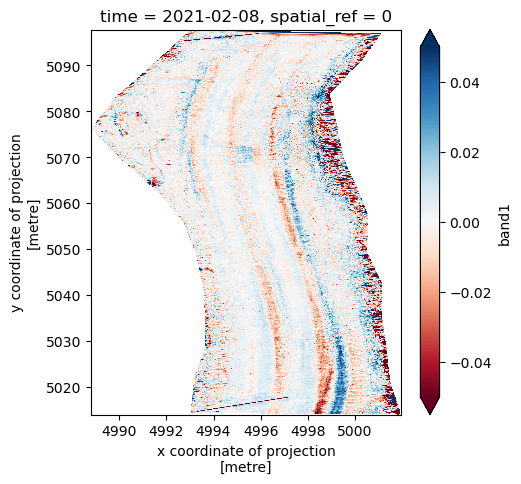

In [18]:
ds_diff.isel(time=0).plot(cmap='RdBu',
            vmin=-0.05,
            vmax=0.05,
            aspect='equal',
            size=5)

## Read shapefile

In [19]:
shapefiles = [x.as_posix() for x in sorted(Path(vector_folder).glob('*.shp'))]
gdf = gpd.read_file(shapefiles[0])

## Plot shapefile

<Axes: title={'center': 'time = 2021-02-08, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

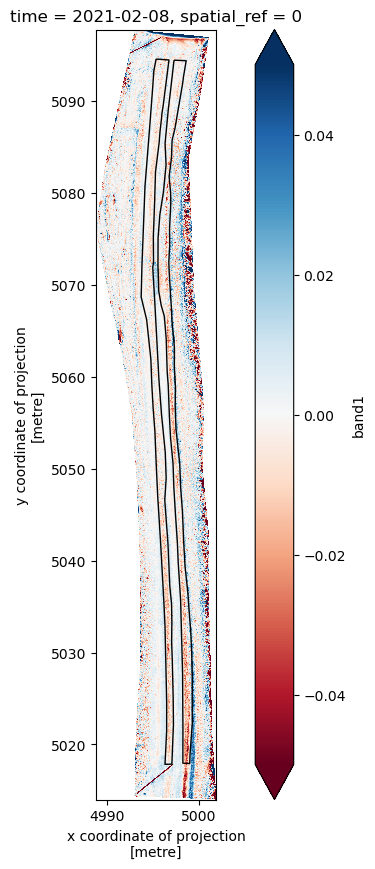

In [20]:
fig,ax = plt.subplots(figsize=(10,10))

ds_diff.isel(time=0).plot(ax=ax,
                          cmap='RdBu',
                          vmin=-0.05,
                          vmax=0.05,
                          )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

gdf.plot(ax=ax, facecolor='none', edgecolor='black')

## Clip stack for each geometry

In [21]:
geometry_0 = gpd.GeoDataFrame(gpd.GeoSeries(gdf.iloc[0]['geometry']), columns=['geometry'])
geometry_1 = gpd.GeoDataFrame(gpd.GeoSeries(gdf.iloc[1]['geometry']), columns=['geometry'])

In [22]:
ds_diff_clip_geom_0 = ds_diff.rio.clip(geometry_0['geometry'])
ds_diff_clip_geom_1 = ds_diff.rio.clip(geometry_1['geometry'])

## Plot first time step in clipped stack

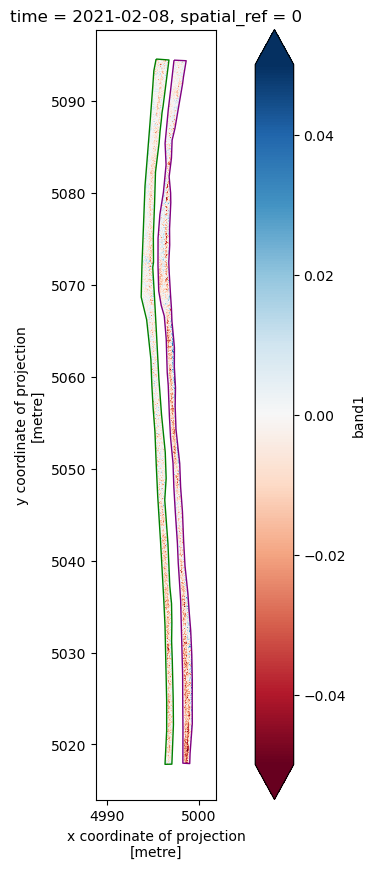

In [23]:
fig,ax = plt.subplots(figsize=(10,10))

ds_diff_clip_geom_0.isel(time=0).plot(ax=ax,
                                      cmap='RdBu',
                                      vmin=-0.05,
                                      vmax=0.05,
                                      add_colorbar=False,
                                     )

geometry_0.plot(ax=ax, facecolor='none', edgecolor='green')

ds_diff_clip_geom_1.isel(time=0).plot(ax=ax,
                                      cmap='RdBu',
                                      vmin=-0.05,
                                      vmax=0.05,
                                      cbar_kwargs={'extend': 'both'},
                                     )

geometry_1.plot(ax=ax, facecolor='none', edgecolor='purple')

ax.set_xlim(xlim)
ax.set_ylim(ylim);

## Plot time series for mean difference value

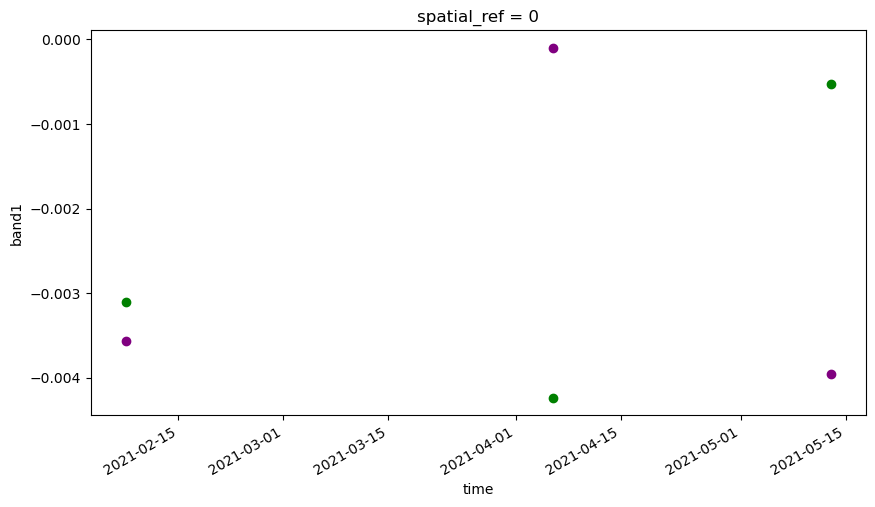

In [26]:
fig,ax = plt.subplots(figsize=(10,5))
ds_diff_clip_geom_0.mean(dim=['x','y']).plot.scatter(ax=ax,color='green')
ds_diff_clip_geom_1.mean(dim=['x','y']).plot.scatter(ax=ax,color='purple')